In [25]:
import pandas as pd
# from hazm import Normalizer, word_tokenize, Stemmer, Lemmatizer, stopwords_list
import re
# from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from sklearn.metrics import silhouette_score, normalized_mutual_info_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD

import pandas as pd
import re
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
from sklearn.metrics import silhouette_score, normalized_mutual_info_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from hazm import Normalizer as hazm_normalizer, word_tokenize, Stemmer, Lemmatizer, stopwords_list
from sklearn.preprocessing import Normalizer as vec_normalizer
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN, MiniBatchKMeans
import string


In [26]:
df = pd.read_csv("./golestan.csv")

print(df.shape)
print(df.columns)


(290, 2)
Index(['hekayt', 'bab'], dtype='object')


In [27]:
df.head()

,hekayt,bab
0,پادشاهی را شنیدم به کُشتنِ اسیری اشارت کرد. بی...,1
1,یکی از ملوکِ خراسان محمودِ سبکتگین را به خواب ...,1
2,ملک‌زاده‌ای را شنیدم که کوتاه بود و حقیر و دیگ...,1
3,طایفهٔ دزدانِ عرب بر سرِ کوهی نشسته بودند و من...,1
4,سرهنگ‌زاده‌ای را بر در سرایِ اُغْلُمُش دیدم که...,1


In [28]:
df = df.dropna(subset=["hekayt"])
df = df.dropna(subset=["bab"])

print(df.shape)
print(df.columns)

(290, 2)
Index(['hekayt', 'bab'], dtype='object')


In [29]:
df["bab"].value_counts()

bab
8    109
2     48
1     41
3     28
5     21
7     20
4     14
6      9
Name: count, dtype: int64

In [30]:
normalizer = hazm_normalizer()
stemmer = Stemmer()
lemmatizer = Lemmatizer()
base_stopwords = set(stopwords_list())

In [31]:
base_stopwords = set(stopwords_list())

In [32]:
extra_stopwords = {
    # your original
    "است", "هست", "بود", "شد", "باشد",
    "می", "هم", "را", "که", "با", "از", "برای",
    "ای", "این", "آن", "من", "تو", "ما", "شما", "او",

    # added – Golestan high-frequency noise
    "پادشاه", "ملک", "شاه", "وزیر", "بنده", "مرد", "یکی", "شخصی",
    "گفت", "گوید", "پرسید", "شنید",
    "چون", "کرد", "کند", "کردند", "بودند", "دید",
    "هر", "بر", "در", "چو", "اگر", "تا", "پس", "اما", "نیز",
    "نصیحت", "حکایت", "داستان", "خلق", "گفتند",
    "بدان", "چنان", "همچنان", "همیشه"
}


additional_stopwords = set()

for i in extra_stopwords:
    print(f'if {i} is in stopwords list? {i in base_stopwords}')
    if i not in base_stopwords: 
        additional_stopwords.add(i)

additional_stopwords

if شما is in stopwords list? True
if اگر is in stopwords list? True
if که is in stopwords list? True
if یکی is in stopwords list? True
if خلق is in stopwords list? False
if پادشاه is in stopwords list? False
if ملک is in stopwords list? False
if کند is in stopwords list? True
if بدان is in stopwords list? False
if دید is in stopwords list? False
if نیز is in stopwords list? True
if می is in stopwords list? True
if هست is in stopwords list? False
if است is in stopwords list? True
if ای is in stopwords list? False
if چون is in stopwords list? True
if تا is in stopwords list? True
if همیشه is in stopwords list? True
if ما is in stopwords list? True
if اما is in stopwords list? True
if در is in stopwords list? True
if بود is in stopwords list? True
if را is in stopwords list? True
if شخصی is in stopwords list? True
if بنده is in stopwords list? False
if پس is in stopwords list? True
if داستان is in stopwords list? False
if من is in stopwords list? True
if کرد is in stopwords list? True
if 

{'ای',
 'بدان',
 'بنده',
 'حکایت',
 'خلق',
 'داستان',
 'دید',
 'شاه',
 'شنید',
 'مرد',
 'ملک',
 'نصیحت',
 'هست',
 'وزیر',
 'پادشاه',
 'پرسید',
 'چنان',
 'چو',
 'گفتند',
 'گوید'}

In [33]:
stopwords = base_stopwords.union(additional_stopwords)

print(len(base_stopwords))
print(len(stopwords))

389
409


In [34]:

# add Persian punctuation
PERSIAN_PUNCT = {"،", "؛", ":", "؟", "«", "»", "…", "ـ"}

def preprocess_hekayat(text):
    # 1) Convert to string
    text = str(text)

    # 2) Normalize Arabic/Persian characters
    text = text.replace("ي", "ی").replace("ك", "ک")

    # 3) Remove zero-width joiner
    text = text.replace("\u200c", " ")

    # 4) Normalize with Hazm
    text = normalizer.normalize(text)

    # 5) Tokenize
    tokens = word_tokenize(text)

    # 6) Keep only Persian alphabet tokens
    tokens = [t for t in tokens if re.search(r"[آ-یءئ]", t)]

    # 7) Remove punctuation
    punct = set(string.punctuation) | PERSIAN_PUNCT
    tokens = [t for t in tokens if t not in punct]

    # 8) Remove stopwords
    tokens = [t for t in tokens if t not in stopwords]

    # 9) Remove numbers
    tokens = [t for t in tokens if not t.isnumeric()]

    # 10) Remove very short tokens (like single letters)
    tokens = [t for t in tokens if len(t) > 1]

    # 11) Lemmatize tokens (better morphological normalization)
    tokens = [lemmatizer.lemmatize(t) for t in tokens]

    # 12) Stem AFTER lemmatization (best practice for Persian)
    tokens = [stemmer.stem(t) for t in tokens]

    # 13) Remove any empty leftovers
    tokens = [t.strip() for t in tokens if t.strip()]

    # 14) Return clean text
    return " ".join(tokens)


In [35]:
df["clean_hekayt"] = df["hekayt"].apply(preprocess_hekayat)

In [36]:
df.to_csv("golestan_clean.csv", index=False)
df[["hekayt", "clean_hekayt"]].head()

,hekayt,clean_hekayt
0,پادشاهی را شنیدم به کُشتنِ اسیری اشارت کرد. بی...,پادشاه شنید#شنو کشتن اسیر اشار بیچاره حال نومی...
1,یکی از ملوکِ خراسان محمودِ سبکتگین را به خواب ...,ملوک خراس محمود سبکتگین خواب جمله ریخت#ریز خاک...
2,ملک‌زاده‌ای را شنیدم که کوتاه بود و حقیر و دیگ...,ملک‌زاده شنید#شنو کوتاه حقیر برادر بلند بار پد...
3,طایفهٔ دزدانِ عرب بر سرِ کوهی نشسته بودند و من...,طایفه دزد عرب سر کوه شست#شو منفذ کارو بسته رع ...
4,سرهنگ‌زاده‌ای را بر در سرایِ اُغْلُمُش دیدم که...,سرهنگ زاد#زا سرود#سرا اغلم دید#بین عقل کیاس فه...


In [37]:

bow_vectorizer = CountVectorizer(
    max_features=8000,
    ngram_range=(1, 1),   # unigrams only
    binary=False          # True = presence/absence, False = raw counts
)

x_bow = bow_vectorizer.fit_transform(df["clean_hekayt"])

svd = TruncatedSVD(n_components=100, random_state=42)
x_bow_reduced = svd.fit_transform(x_bow)
normalizer_vec = vec_normalizer()
X_final = normalizer_vec.fit_transform(x_bow_reduced)

In [38]:
bow_feature_names = bow_vectorizer.get_feature_names_out()
bow_feature_names[:30]

array(['آب', 'آباد', 'آبرو', 'آبگینه', 'آت', 'آتش', 'آثار', 'آجل', 'آحاد',
       'آخر', 'آد', 'آداب', 'آدم', 'آدمیس', 'آدینه', 'آذارند', 'آر',
       'آرا', 'آراستن', 'آراسته', 'آرد', 'آرزو', 'آرمیده', 'آز', 'آزاد',
       'آزادگ', 'آزار', 'آزر', 'آزردن', 'آزرده'], dtype=object)

In [39]:
k = 5
kmeans = MiniBatchKMeans(
    n_clusters=k,
    init="k-means++",
    n_init=20,
    max_iter=300,
    batch_size=256,
    random_state=42
)
kmeans.fit(X_final)
labels = kmeans.fit_predict(X_final)


In [40]:
# cluster sizes
unique, counts = np.unique(labels, return_counts=True)
for lbl, cnt in zip(unique, counts):
    print(f"Cluster {lbl}: {cnt} hekayat")

Cluster 0: 21 hekayat
Cluster 1: 90 hekayat
Cluster 2: 23 hekayat
Cluster 3: 96 hekayat
Cluster 4: 60 hekayat


In [41]:
threshold = 0.15 * np.mean(counts)
print("Are clusters balanced?", np.std(counts) < threshold)


Are clusters balanced? False


In [42]:
sil = silhouette_score(X_final, labels)
nmi = normalized_mutual_info_score(df["bab"], labels)

print("silhouette:", sil)
print("NMI:", nmi)

silhouette: 0.03341221474043767
NMI: 0.08646129961135006


In [43]:
centers = kmeans.cluster_centers_
feature_names = bow_vectorizer.get_feature_names_out()

for idx, center in enumerate(centers):
    print(f"\nCluster {idx} top terms:")
    top_indices = center.argsort()[::-1][:10]
    for i in top_indices:
        print(f"  {feature_names[i]}  ({center[i]:.3f})")


Cluster 0 top terms:
  آب  (0.286)
  آشفته  (0.148)
  آذارند  (0.098)
  آزما  (0.096)
  آش  (0.096)
  آل  (0.092)
  آزار  (0.084)
  آمد  (0.083)
  آراسته  (0.070)
  آدمیس  (0.069)

Cluster 1 top terms:
  آب  (0.436)
  آبرو  (0.136)
  آبگینه  (0.074)
  آحاد  (0.065)
  آد  (0.045)
  آثار  (0.038)
  آزرده  (0.028)
  آشامید  (0.026)
  آزاد  (0.021)
  آشنا  (0.021)

Cluster 2 top terms:
  آب  (0.293)
  آدینه  (0.135)
  آزر  (0.116)
  آتش  (0.087)
  آسوده  (0.084)
  آراستن  (0.081)
  آشامید  (0.070)
  آذارند  (0.070)
  آدمیس  (0.063)
  آمد  (0.055)

Cluster 3 top terms:
  آب  (0.251)
  آشا  (0.059)
  آسیا  (0.047)
  آشکارا  (0.039)
  آد  (0.037)
  آسان  (0.034)
  آشنا  (0.034)
  آویخت  (0.033)
  آز  (0.030)
  أذ  (0.029)

Cluster 4 top terms:
  آب  (0.340)
  آتش  (0.183)
  آجل  (0.094)
  آبرو  (0.088)
  آراستن  (0.055)
  آدم  (0.053)
  آخر  (0.044)
  آداب  (0.042)
  آرد  (0.038)
  آزردن  (0.038)


K= 2 → Inertia=245.65, Sil=0.0236, NMI=0.0155, Sizes=[C0=192, C1=98]
K= 3 → Inertia=238.67, Sil=0.0281, NMI=0.0300, Sizes=[C0=76, C1=70, C2=144]
K= 4 → Inertia=233.30, Sil=0.0305, NMI=0.0509, Sizes=[C0=94, C1=46, C2=127, C3=23]
K= 5 → Inertia=227.06, Sil=0.0351, NMI=0.0748, Sizes=[C0=97, C1=43, C2=64, C3=21, C4=65]
K= 6 → Inertia=221.48, Sil=0.0392, NMI=0.0767, Sizes=[C0=49, C1=36, C2=87, C3=20, C4=42, C5=56]
K= 7 → Inertia=219.32, Sil=0.0404, NMI=0.0762, Sizes=[C0=48, C1=35, C2=69, C3=20, C4=42, C5=58, C6=18]
K= 8 → Inertia=217.41, Sil=0.0304, NMI=0.0915, Sizes=[C0=31, C1=37, C2=18, C3=37, C4=41, C5=60, C6=31, C7=35]
K= 9 → Inertia=214.75, Sil=0.0311, NMI=0.1026, Sizes=[C0=21, C1=35, C2=18, C3=27, C4=49, C5=65, C6=21, C7=34, C8=20]
K=10 → Inertia=212.68, Sil=0.0283, NMI=0.1219, Sizes=[C0=18, C1=32, C2=18, C3=27, C4=44, C5=52, C6=21, C7=32, C8=20, C9=26]
K=11 → Inertia=211.05, Sil=0.0290, NMI=0.1203, Sizes=[C0=20, C1=35, C2=18, C3=21, C4=36, C5=47, C6=21, C7=29, C8=17, C9=22, C10=24]
K

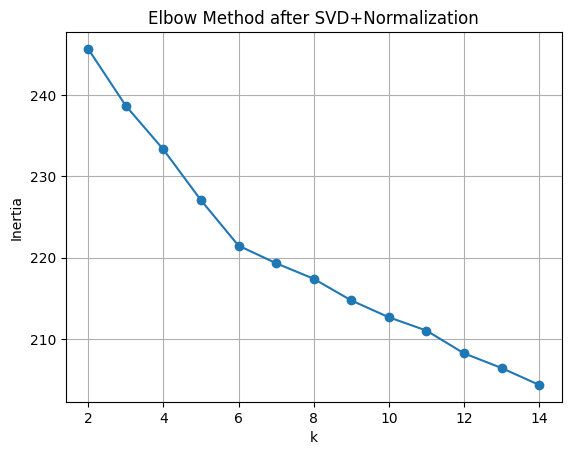

In [44]:
from sklearn.metrics import silhouette_score, normalized_mutual_info_score
import numpy as np

k_values = range(2, 15)
inertias = []

for k in k_values:
    # fit a fresh KMeans for this k
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_final)

    # inertia for elbow
    inertias.append(km.inertia_)

    # clustering metrics
    labels = km.labels_
    inertia = km.inertia_
    sil = silhouette_score(X_final, labels)
    nmi = normalized_mutual_info_score(df["bab"], labels)

    unique, counts = np.unique(labels, return_counts=True)
        # cast to plain Python ints and format nicely
    sizes_str = ", ".join(
        f"C{int(c)}={int(cnt)}" for c, cnt in zip(unique, counts)
    )

    print(
        f"K={k:2d} → Inertia={inertia:.2f}, "
        f"Sil={sil:.4f}, NMI={nmi:.4f}, Sizes=[{sizes_str}]"
    )


# elbow plot
plt.plot(k_values, inertias, marker='o')
plt.title("Elbow Method after SVD+Normalization")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


In [45]:
def plot_clusters_tsne(X, labels):

    tsne = TSNE(
        n_components=2,
        perplexity=30,
        learning_rate="auto",
        init="pca",
        random_state=42
    )

    

    X_2d = tsne.fit_transform(X.toarray())

    plt.figure(figsize=(10, 7))
    plt.scatter(
        X_2d[:, 0],
        X_2d[:, 1],
        c=labels,
        cmap="tab10",
        s=50,
        alpha=0.90
    )

    plt.title("t-SNE Projection of K-Means Clusters", fontsize=14)
    plt.xlabel("t-SNE Component 1")
    plt.ylabel("t-SNE Component 2")
    plt.grid(False)
    plt.show()


In [46]:
k = 5
kmeans_final, labels_final = fit_kmeans(x_bow_reduced, k)

# cluster sizes
unique, counts = np.unique(labels_final, return_counts=True)
for lbl, cnt in zip(unique, counts):
    print(f"Cluster {lbl}: {cnt} hekayat")

threshold = 0.15 * np.mean(counts)
print("Are clusters balanced?", np.std(counts) < threshold)

# cluster–bab relationship
df_clusters = pd.DataFrame({
    "cluster": labels_final,
    "bab": df["bab"]
})
cluster_groups = df_clusters.groupby("cluster")["bab"].value_counts()
print(cluster_groups)

nmi = normalized_mutual_info_score(df["bab"], labels_final)
print("NMI:", nmi)



NameError: name 'fit_kmeans' is not defined

In [ ]:
kmeans_model, labels = fit_kmeans(x_bow_reduced, k)

centers = kmeans_model.cluster_centers_
print("Cluster centers shape:", centers.shape)


Cluster centers shape: (5, 100)


In [ ]:
def show_cluster_top_terms(kmeans_model, vectorizer, top_n=10):
    centers = kmeans_model.cluster_centers_
    feature_names = vectorizer.get_feature_names_out()

    for idx, center in enumerate(centers):
        print(f"\nCluster {idx} top terms:")
        top_indices = center.argsort()[::-1][:top_n]
        for i in top_indices:
            print(f"  {feature_names[i]}  ({center[i]:.3f})")


In [ ]:
show_cluster_top_terms(kmeans_model, bow_vectorizer, top_n=10)



Cluster 0 top terms:
  آب  (1.907)
  آبگینه  (0.656)
  آت  (0.358)
  آثار  (0.313)
  آرا  (0.176)
  آداب  (0.159)
  آتش  (0.156)
  آدینه  (0.139)
  آزموده  (0.109)
  آمده  (0.093)

Cluster 1 top terms:
  آب  (20.588)
  آبگینه  (15.389)
  آحاد  (3.971)
  آبرو  (2.107)
  آجل  (1.876)
  آدم  (1.072)
  آزاد  (0.951)
  آر  (0.926)
  آخر  (0.645)
  آغاز  (0.608)

Cluster 2 top terms:
  آب  (49.848)
  آجل  (0.889)
  آدمی  (0.704)
  آمده_بود  (0.332)
  آشوب  (0.304)
  آسیا  (0.300)
  آمیز  (0.243)
  آزر  (0.220)
  آمدند  (0.187)
  آهن  (0.183)

Cluster 3 top terms:
  آب  (15.293)
  آت  (11.917)
  آبگینه  (9.921)
  آجل  (3.011)
  آبرو  (1.579)
  آد  (1.173)
  آزادگ  (1.081)
  آدمیس  (0.951)
  آخر  (0.897)
  آحاد  (0.810)

Cluster 4 top terms:
  آب  (44.863)
  آبرو  (31.652)
  آجل  (1.528)
  آتش  (0.861)
  آدمی  (0.621)
  آستین  (0.516)
  آسان  (0.431)
  آسیا  (0.337)
  آن  (0.334)
  آزار  (0.318)


In [ ]:
for k in range(1, 20):
    kmeans_model, cluster_labels = fit_kmeans(x_bow_reduced, k)
    # plot_clusters_tsne(x_bow_reduced, cluster_labels)

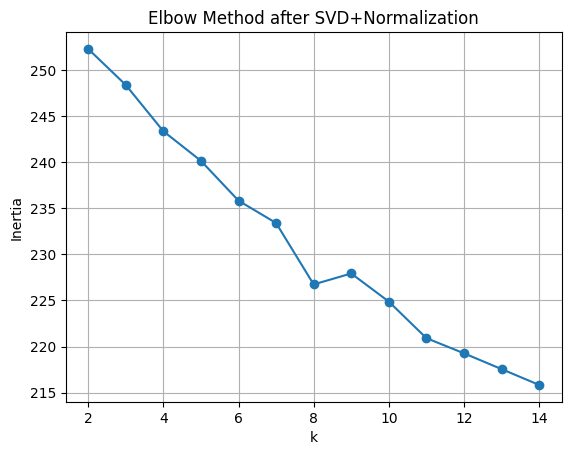

In [ ]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer

# Step 1: Dimensionality reduction
svd = TruncatedSVD(n_components=100, random_state=42)
X_reduced = svd.fit_transform(x_bow_reduced)

# Step 2: Normalize for cosine-like KMeans
normalizer = Normalizer()
X_final = normalizer.fit_transform(X_reduced)

# Step 3: Elbow method
inertias = []
for k in range(2, 15):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_final)
    inertias.append(km.inertia_)

plt.plot(range(2, 15), inertias, marker='o')
plt.title("Elbow Method after SVD+Normalization")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.grid(True)
plt.show()


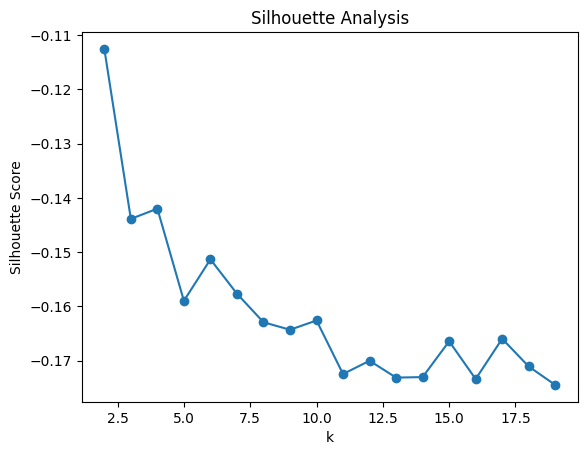

In [ ]:
# -----*** Silhouette Score ***-----
sil_scores = []

for k in range(2, 20):
    km, labels = fit_kmeans(x_bow_reduced, k)
    score = silhouette_score(x_bow_reduced, labels, metric="cosine")
    sil_scores.append(score)

plt.plot(range(2, 20), sil_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette Score")
plt.title("Silhouette Analysis")
plt.show()


In [ ]:
print("Best k by silhouette:", np.argmax(sil_scores))

Best k by silhouette: 0


K=4


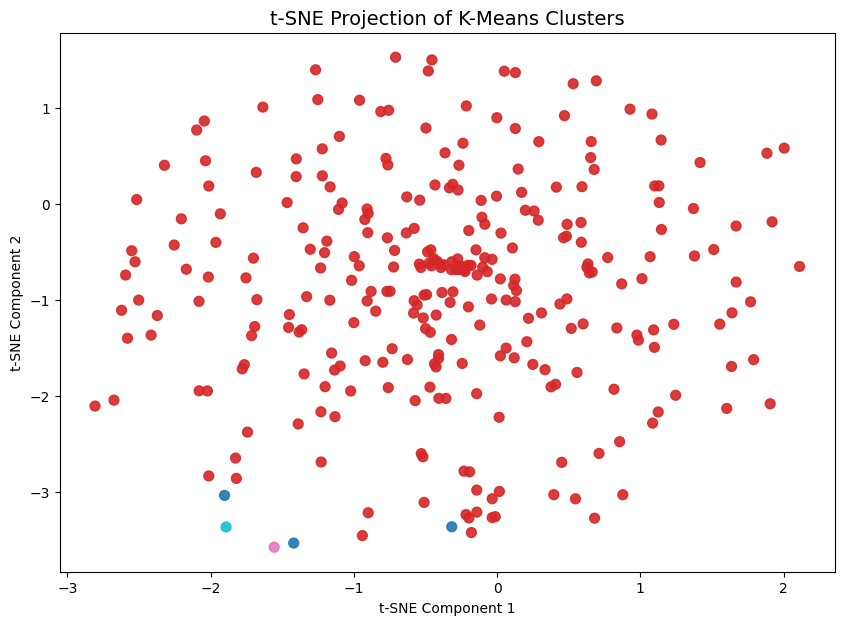

K=5


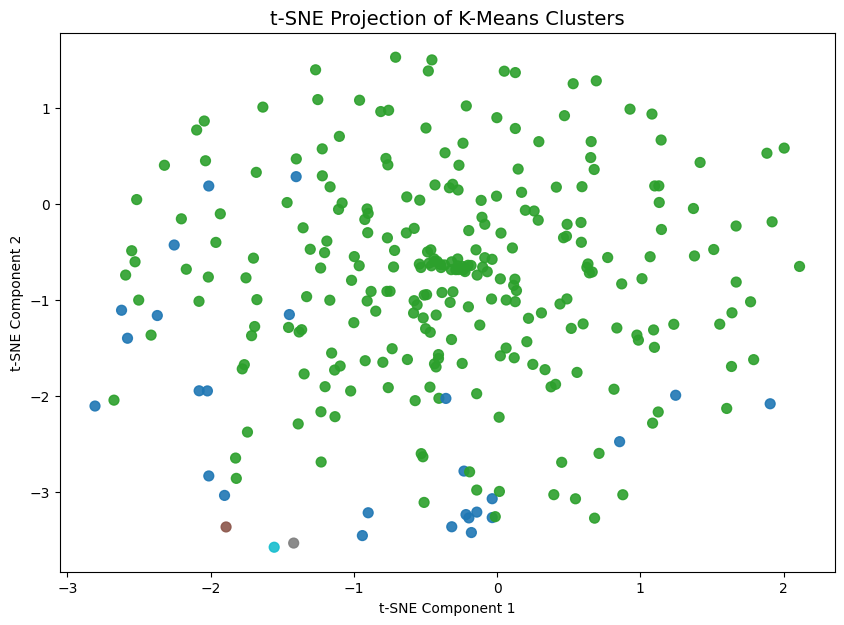

K=6


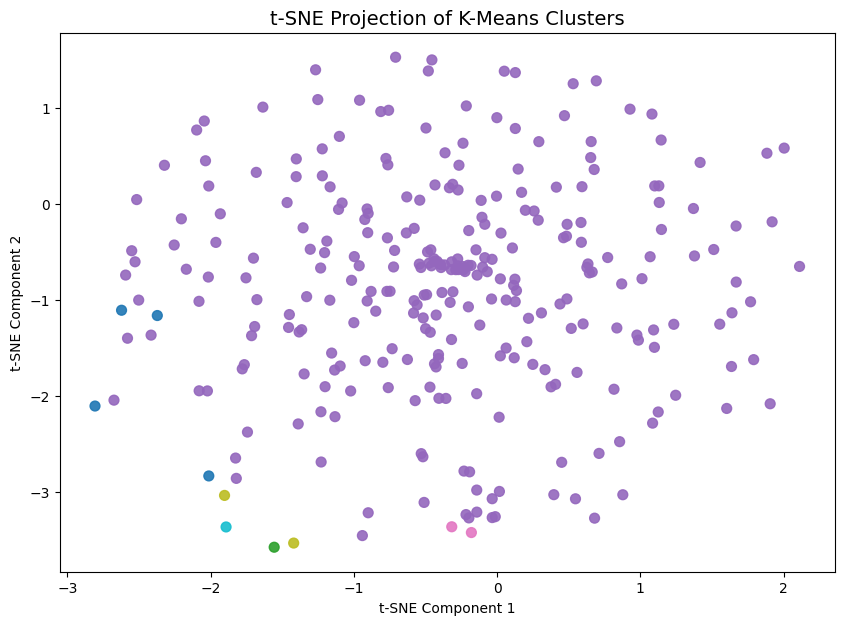

K=7


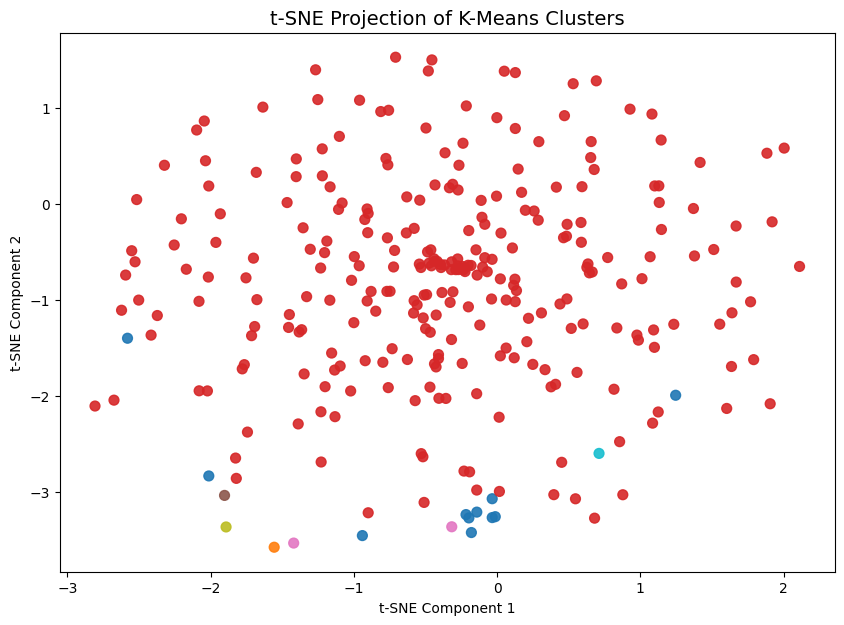

In [ ]:
for k in range(4, 8):
    print(f"K={k}")
    kmeans, labels = fit_kmeans(x_bow, k)
    plot_clusters_tsne(x_bow, labels)


Mathematical answer

→ k = 2

Semantically meaningful clustering

→ k = 4, 5, 6, or 7

Closest to Golestan’s 8 bāb

→ k = 8